<a href="https://colab.research.google.com/github/PaulNjinu254/Clustering-Series/blob/main/Clustering_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Wholesale customers data.csv to Wholesale customers data.csv


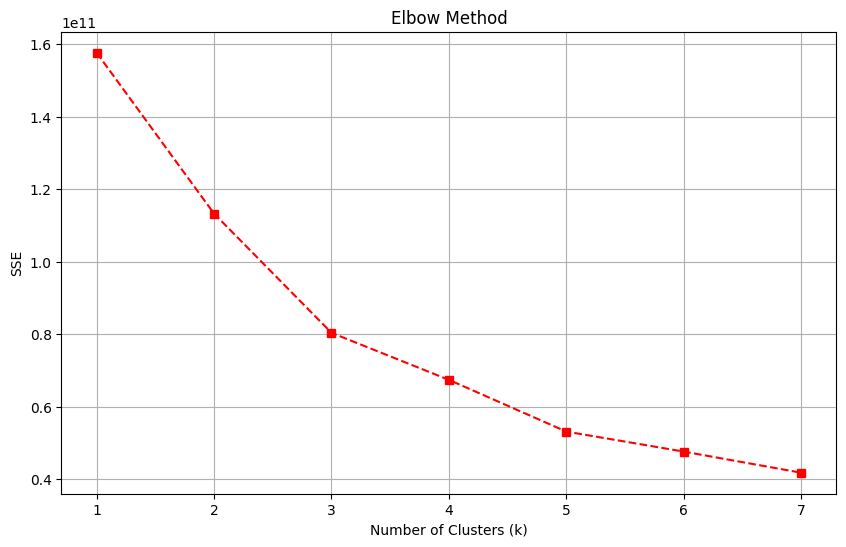

                               Fresh                         Milk         \
                                mean     max    min          mean    max   
Channel Region cluster                                                     
1       1      0        34673.500000   56083  22096   4639.100000  11487   
               1         8759.666667   23257    514   2941.800000  17972   
               3         5078.250000    6202   2806  12392.500000  23527   
        2      0        29443.000000   32717  25977   7568.666667  16784   
               1         9515.440000   22321      3   1672.520000   3696   
        3      0        38508.783784  112151  23632   5119.378378  29627   
               1         8589.280488   22686      3   2651.097561  18664   
               2        36847.000000   36847  36847  43950.000000  43950   
               3         6439.444444   18291     97   7511.777778  21858   
2       1      1         9296.250000   20782   2541   4793.500000   5989   
            

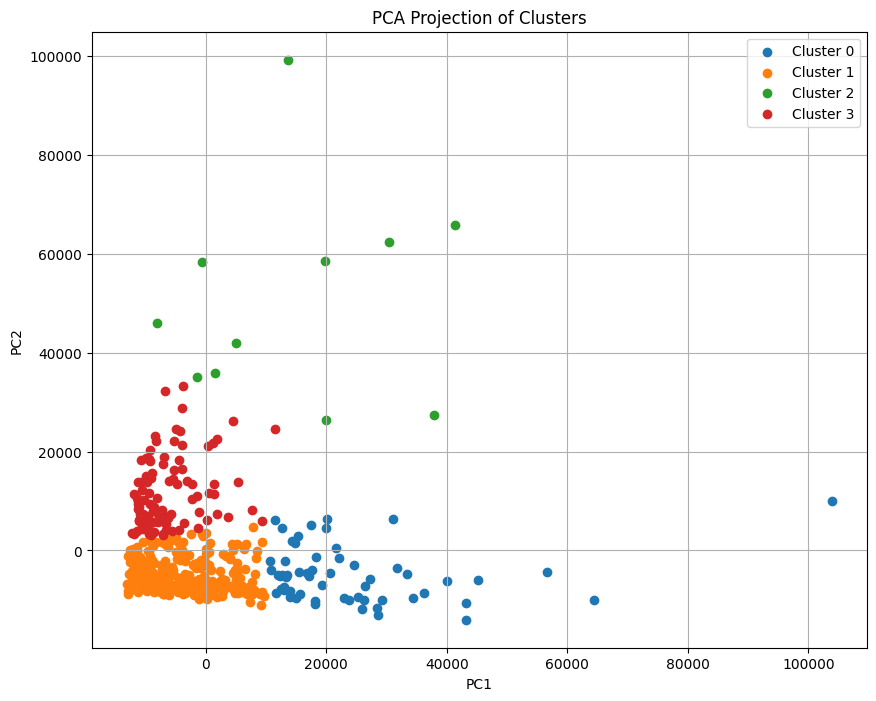

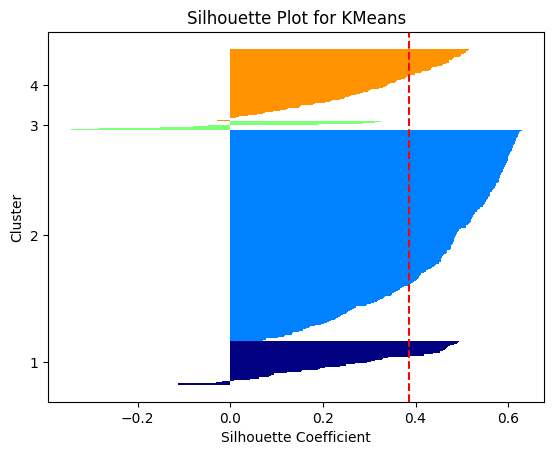

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

# Scratch KMeans implementation
class ScratchKMeans():
    def __init__(self, n_clusters=2, n_init=5, n_iter=100, verbose=False):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.n_iter = n_iter
        self.verbose = verbose
        self.best_sse = float('inf')

    def _init_myu(self, X):
        return X[np.random.choice(len(X), size=self.n_clusters, replace=False)]

    def _calc_sse(self, X):
        sse = 0
        for i in range(len(X)):
            cluster_id = int(X[i, -1])
            sse += np.sum((X[i, :-1] - self.myu[cluster_id]) ** 2)
        if sse < self.best_sse:
            self.best_sse = sse
            self.record_myu = self.myu.copy()
            self.record_cluster = self.n_clusters

    def _update_cluster(self, X):
        for i in range(len(X)):
            distances = [np.linalg.norm(X[i, :-1] - mu) for mu in self.myu]
            X[i, -1] = np.argmin(distances)

    def _update_myu(self, X):
        for j in range(self.n_clusters):
            self.myu[j] = np.mean(X[X[:, -1] == j, :-1], axis=0)

    def fit(self, X):
        for i in range(self.n_init):
            self.myu = self._init_myu(X)
            cluster = np.zeros(len(X))
            X_cluster = np.concatenate([X.copy(), cluster.reshape(-1, 1)], axis=1)
            for j in range(self.n_iter):
                self._calc_sse(X_cluster)
                self._update_cluster(X_cluster)
                self._update_myu(X_cluster)
                if self.verbose:
                    print(f"Init: {i} | Iter: {j} | Best SSE: {self.best_sse}")
        self.myu = self.record_myu
        self.n_clusters = self.record_cluster

    def predict(self, X):
        y_pred = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            distances = [np.linalg.norm(X[i] - mu) for mu in self.record_myu]
            y_pred[i] = np.argmin(distances)
        return y_pred

# Load data
from google.colab import files
uploaded = files.upload()
data = pd.read_csv("Wholesale customers data.csv")
X = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].values

# Elbow Method
elbow = {}
for k in range(1, 8):
    model = ScratchKMeans(n_clusters=k, n_init=3, n_iter=50, verbose=False)
    model.fit(X)
    elbow[k] = model.best_sse

plt.figure(figsize=(10, 6))
plt.plot(list(elbow.keys()), list(elbow.values()), 'rs--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Final model with k = 4
k = 4
clf = ScratchKMeans(n_clusters=k, n_init=5, n_iter=100, verbose=False)
clf.fit(X)
pred = clf.predict(X)

data['cluster'] = pred

# Group summary
summary = data.groupby(['Channel', 'Region', 'cluster']).agg(['mean', 'max', 'min'])
print(summary)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
for label in np.unique(pred):
    plt.scatter(X_pca[pred == label, 0], X_pca[pred == label, 1], label=f"Cluster {label}")
plt.title("PCA Projection of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

# Silhouette Analysis
silhouette_vals = silhouette_samples(X, pred)
silhouette_avg = silhouette_score(X, pred)
cluster_labels = np.unique(pred)

# Silhouette Plot
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[pred == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / k)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette Coefficient")
plt.title("Silhouette Plot for KMeans")
plt.show()
